In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Préparation du device et des données
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [5]:
def prune_model(model):
    prune.l1_unstructured(model.conv1, name="weight", amount=0.5)
    prune.l1_unstructured(model.conv2, name="weight", amount=0.5)
    return model


In [6]:
def train(model, trainloader, epochs=5):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    losses = []

    for epoch in range(epochs):
        total_loss = 0.0
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(trainloader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}")
        losses.append(avg_loss)

    # Affichage de la courbe de perte
    plt.plot(losses, marker='o')
    plt.title("Loss après Pruning")
    plt.xlabel("Époques")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


In [7]:
def show_pruned_weights(layer):
    weight = layer.weight.detach().cpu().numpy()
    mask = layer.weight_mask.detach().cpu().numpy()
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(weight[0, 0], cmap='gray')
    plt.title("Poids bruts")
    plt.subplot(1, 2, 2)
    plt.imshow(mask[0, 0], cmap='gray')
    plt.title("Masque (poids actifs)")
    plt.show()


Epoch 1, Loss: 0.32985255362859156
Epoch 2, Loss: 0.08711100169030556
Epoch 3, Loss: 0.0618135664105189
Epoch 4, Loss: 0.048472113617912316
Epoch 5, Loss: 0.04041282871431772


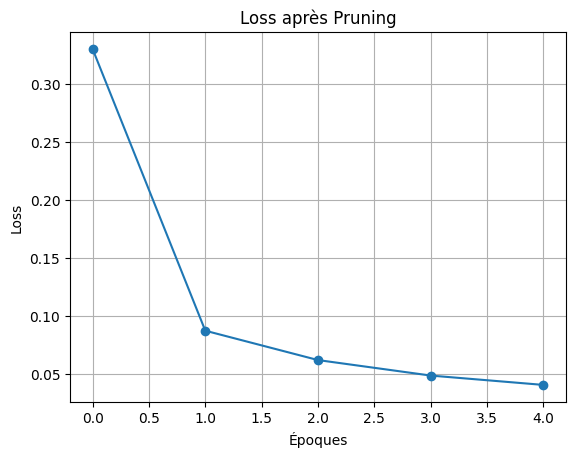

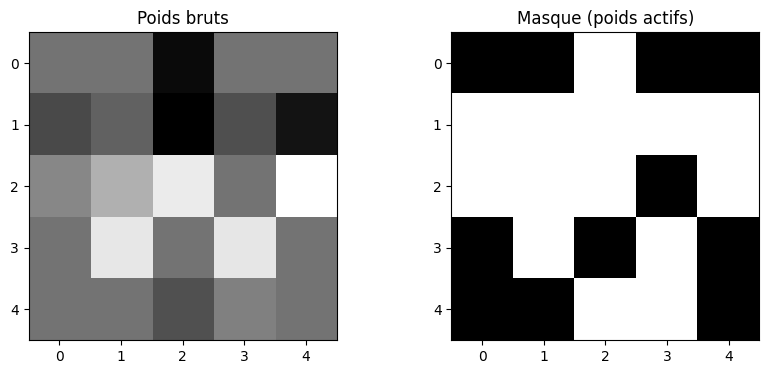

In [8]:
model = LeNet().to(device)
model = prune_model(model)
train(model, trainloader)
show_pruned_weights(model.conv1)
